# 📌 Project Overview

This notebook focuses on predicting the **Air Quality Index (AQI)** for various cities using **date** and **location-based features**. The goal is to build robust machine learning models that can accurately estimate AQI levels, helping inform public health decisions and environmental monitoring.

We explore multiple algorithms and apply **model tuning techniques** to enhance prediction accuracy. The workflow includes:

- Data preprocessing and feature engineering
- Exploratory data analysis (EDA)
- Training and evaluation of various ML models
- Hyperparameter optimization
- Final model selection and insights

## 📦 Library Imports

To build and evaluate AQI prediction models, we utilize a combination of **data manipulation**, **visualization**, and **machine learning** libraries:

### 🔹 Core Libraries
- `pandas`, `numpy`: For data handling and numerical operations
- `matplotlib.pyplot`, `seaborn`: For data visualization

### 🔹 File Handling
- `os`, `glob`: For navigating directories and loading multiple files

### 🔹 Machine Learning & Preprocessing
- `sklearn.model_selection`: For train-test splitting and hyperparameter tuning
- `sklearn.preprocessing`: For encoding categorical variables
- `sklearn.metrics`: For evaluating model performance
- `sklearn.linear_model`: For linear regression modeling
- `sklearn.ensemble`: For ensemble models like Random Forest and Gradient Boosting
- `xgboost`: For advanced gradient boosting via `XGBRegressor`

These libraries form the foundation for our end-to-end AQI prediction pipeline.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

## 🧹 AQI Data Preprocessing

To prepare the AQI data for modeling, we define a function `process_aqi_files()` that:

### 🔍 Purpose
Processes multiple `.xlsx` files containing daily AQI data for various cities, extracts relevant information, and consolidates it into clean CSV files.

### 🛠️ Key Steps
- **File Discovery**: Uses `glob` to locate files matching the pattern `AQI_daily_city_level_<city>_*.xlsx`
- **Header Detection**: Dynamically identifies the header row by searching for month names (e.g., "January")
- **Data Cleaning**:
  - Drops empty columns
  - Filters rows where `'Day'` is a valid digit
  - Selects only month columns and melts them into long format
- **Date Construction**: Combines `'Day'`, `'Month'`, and `'Year'` to create a proper `datetime` object
- **City-wise Aggregation**: Saves cleaned data for each city into `<city>_aqi_combined.csv`
- **Global Aggregation**: Combines all cities into a single file `all_cities_aqi_combined.csv`

### 🏙️ Cities Processed
```python
cities_list = ["delhi", "mumbai", "gurugram", "pune", "bengaluru", "chennai", "kolkata", "agra"]

In [19]:
import pandas as pd
import os
import glob

def process_aqi_files(cities, data_directory='.'):
    all_cities_data = []

    for city in cities:
        print(f"Processing city: {city}")
        file_pattern = os.path.join(data_directory, f"AQI_daily_city_level_{city}_*.xlsx")
        all_files = glob.glob(file_pattern)

        if not all_files:
            print(f"No files found for {city}. Skipping.")
            continue

        processed_dfs = []

        for file in all_files:
            file_name = os.path.basename(file)
            print(f"Processing file: {file_name}")

            temp_df = pd.read_excel(file, header=None)

            header_row_idx = None
            for i in range(len(temp_df)):
                if 'January' in temp_df.iloc[i].values:
                    header_row_idx = i
                    break

            if header_row_idx is None:
                print(f"Could not find header row in {file_name}. Skipping.")
                continue

            df = pd.read_excel(file, header=header_row_idx)
            df = df.dropna(axis=1, how='all')
            df = df[df['Day'].apply(lambda x: str(x).isdigit())]

            possible_months = ['January','February','March','April','May','June',
                               'July','August','September','October','November','December']
            month_columns = [m for m in possible_months if m in df.columns]

            if not month_columns:
                print(f"No month columns found in {file_name}. Skipping.")
                continue

            df = df[['Day'] + month_columns]

            melted_df = df.melt(id_vars=['Day'], value_vars=month_columns,
                                var_name='Month', value_name='AQI')

            try:
                year = int(file_name.split('_')[-3])
            except Exception:
                print(f"Could not extract year from filename {file_name}. Skipping.")
                continue

            melted_df['Year'] = year
            melted_df['City'] = city.capitalize()

            melted_df['Date'] = pd.to_datetime(
                melted_df['Day'].astype(str) + '-' + melted_df['Month'] + '-' + melted_df['Year'].astype(str),
                format='%d-%B-%Y', errors='coerce'
            )

            melted_df.dropna(subset=['Date'], inplace=True)

            final_df = melted_df[['City', 'Date', 'AQI']]
            processed_dfs.append(final_df)

        if processed_dfs:
            city_combined_df = pd.concat(processed_dfs, ignore_index=True)
            city_combined_df.to_csv(f"{city.lower()}_aqi_combined.csv", index=False)
            print(f"Saved {city.lower()}_aqi_combined.csv with {len(city_combined_df)} rows")
            all_cities_data.append(city_combined_df)
        else:
            print(f"No valid data processed for {city}")

    if all_cities_data:
        full_df = pd.concat(all_cities_data, ignore_index=True)
        full_df.to_csv("all_cities_aqi_combined.csv", index=False)
        print(f"Saved all_cities_aqi_combined.csv with {len(full_df)} total rows")
    else:
        print("No data processed for any city.")

# Run for multiple cities
cities_list = ["delhi", "mumbai", "gurugram", "pune", "bengaluru", "chennai", "kolkata", "agra"]
process_aqi_files(cities_list, data_directory='.')

Processing city: delhi
Processing file: AQI_daily_city_level_delhi_2021_delhi_2021.xlsx
Could not find header row in AQI_daily_city_level_delhi_2021_delhi_2021.xlsx. Skipping.
Processing file: AQI_daily_city_level_delhi_2022_delhi_2022.xlsx
Processing file: AQI_daily_city_level_delhi_2023_delhi_2023.xlsx
Processing file: AQI_daily_city_level_delhi_2024_delhi_2024.xlsx
Processing file: AQI_daily_city_level_delhi_2025_delhi_2025.xlsx
Saved delhi_aqi_combined.csv with 1216 rows
Processing city: mumbai
Processing file: AQI_daily_city_level_mumbai_2021_mumbai_2021.xlsx
Processing file: AQI_daily_city_level_mumbai_2022_mumbai_2022.xlsx
Processing file: AQI_daily_city_level_mumbai_2023_mumbai_2023.xlsx
Processing file: AQI_daily_city_level_mumbai_2024_mumbai_2024.xlsx
Processing file: AQI_daily_city_level_mumbai_2025_mumbai_2025.xlsx
Saved mumbai_aqi_combined.csv with 1581 rows
Processing city: gurugram
Processing file: AQI_daily_city_level_gurugram_2021_gurugram_2021.xlsx
Processing file: AQ

## 📈 AQI Trends Over Time

To visualize how air quality varies across different cities over time, we generate a **multi-line plot** using Matplotlib:

### 🔍 Steps Involved
- **Data Loading**: Read the combined AQI dataset from `all_cities_aqi_combined.csv`
- **Datetime Conversion**: Ensure the `'Date'` column is in proper `datetime` format for accurate plotting
- **City-wise Plotting**:
  - Loop through each unique city
  - Sort data by date to maintain chronological order
  - Plot AQI values over time for each city

### 📊 Plot Features
- **Figure Size**: Wide layout (`40x8`) to accommodate long time series
- **Legend**: Displays city names, positioned outside the plot for clarity
- **Gridlines**: Improve readability of AQI fluctuations
- **Layout Adjustment**: `tight_layout()` ensures labels and legend are not clipped

### 💾 Output
The final plot is saved as:
```python
aqi_cities_line_graph.png

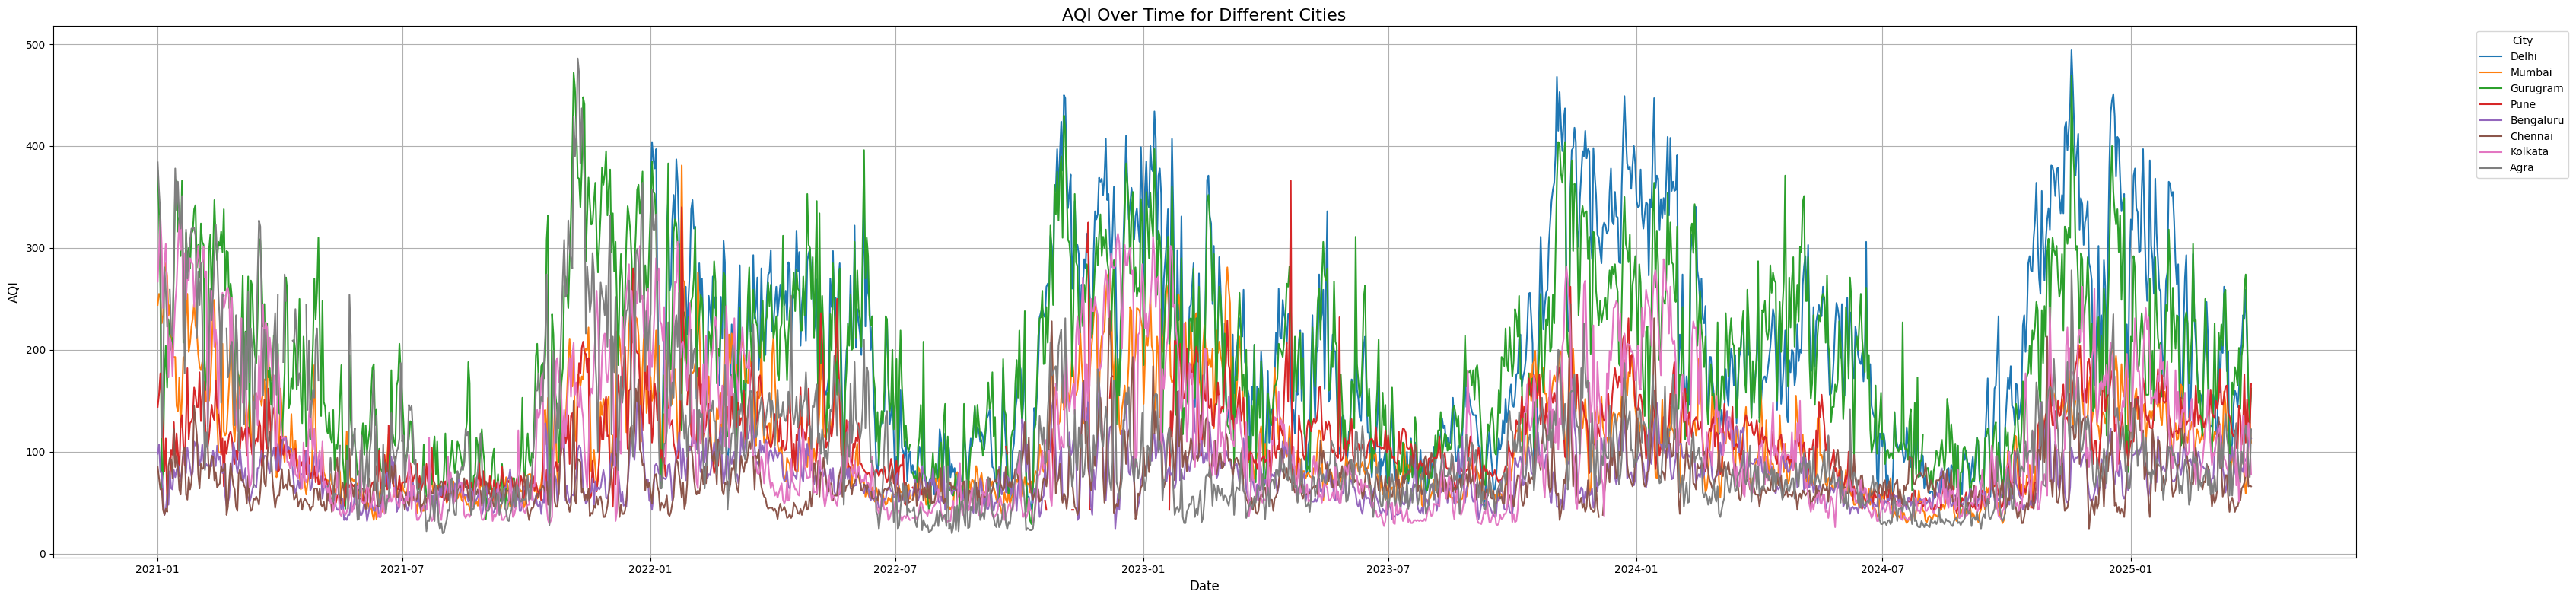

In [3]:
# Load the combined data file
df = pd.read_csv('all_cities_aqi_combined.csv')

# Ensure the 'Date' column is in datetime format for plotting
df['Date'] = pd.to_datetime(df['Date'])

# Get a list of unique cities
cities = df['City'].unique()

# Create the plot
plt.figure(figsize=(40, 8))

# Plot each city's data
for city in cities:
    city_df = df[df['City'] == city]
    # Sort by date to ensure the line is drawn correctly
    city_df = city_df.sort_values('Date')
    plt.plot(city_df['Date'], city_df['AQI'], label=city)

# Add titles and labels
plt.title('AQI Over Time for Different Cities', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Improve layout to make sure labels don't get cut off
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Save the plot to a file
output_image_path = 'aqi_cities_line_graph.png'
plt.savefig(output_image_path)

## 🧼 Data Cleaning & 📊 Outlier Detection

This section focuses on **handling missing AQI values** and identifying **outliers** using box plots.

### 📥 Data Loading
- Attempts to load `all_cities_aqi_combined.csv`
- If the file is missing, the script exits gracefully with an error message

### 🧪 Null Value Imputation
- Checks for missing AQI values
- Fills `NaN` entries using the **mean AQI of each respective city**
- Ensures no null values remain after imputation

### 📅 Date Conversion
- Converts the `'Date'` column to `datetime` format for consistency in downstream analysis

### 📦 Box Plot Generation
- Iterates through each city in the dataset
- Generates a **horizontal box plot** of AQI values to visualize:
  - Distribution
  - Central tendency
  - Potential outliers
- Skips plotting for cities with no valid AQI data

### 📌 Output
- Box plots are displayed inline for each city
- Useful for spotting cities with high AQI variability or extreme pollution events

> 💡 *Box plots are a powerful tool for identifying anomalies and guiding further data cleaning or modeling decisions.*

In [4]:
df.isnull().sum()

City      0
Date      0
AQI     436
dtype: int64

File 'all_cities_aqi_combined.csv' loaded successfully.

Handling Null AQI Values
Number of null values before imputation: 436
Number of null values after imputation: 0

Generating Box Plots for Outlier Detection


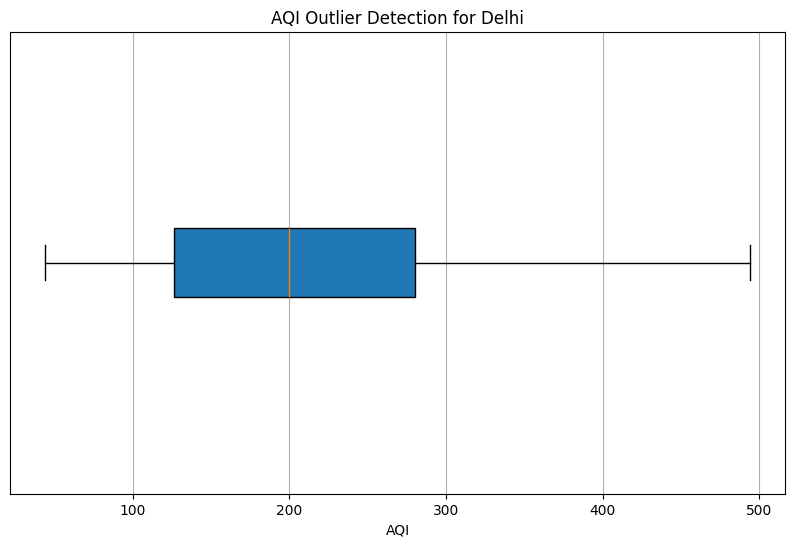

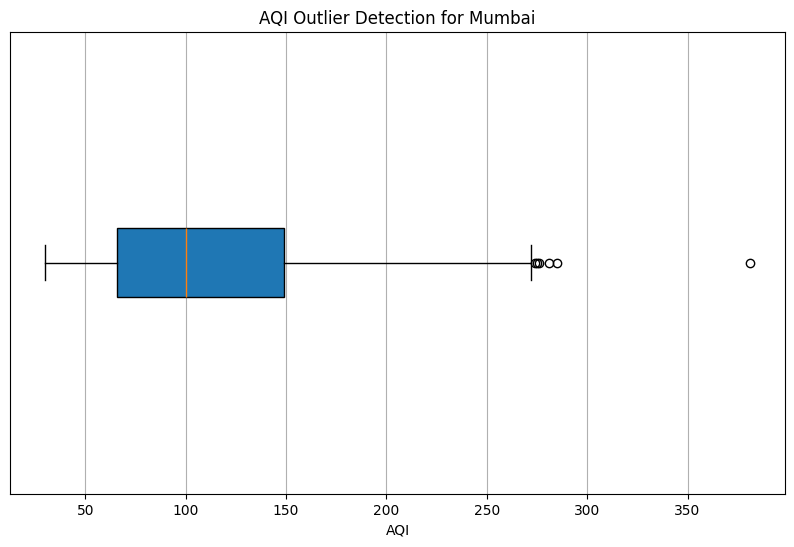

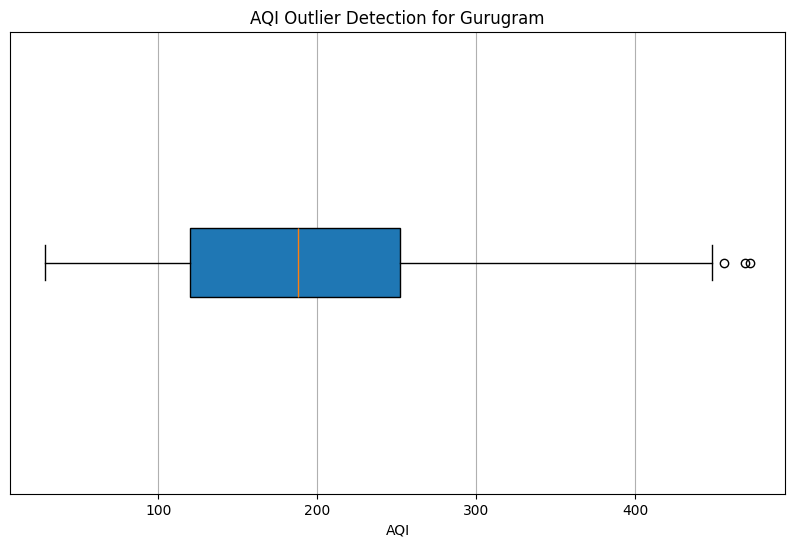

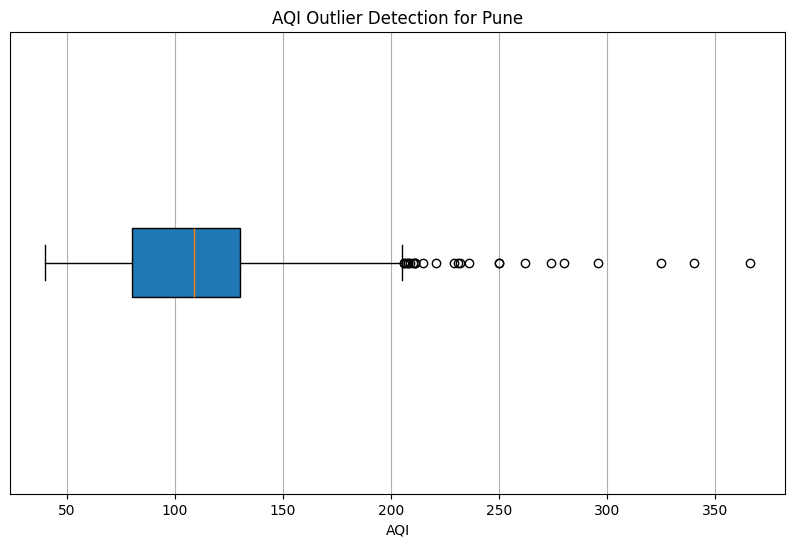

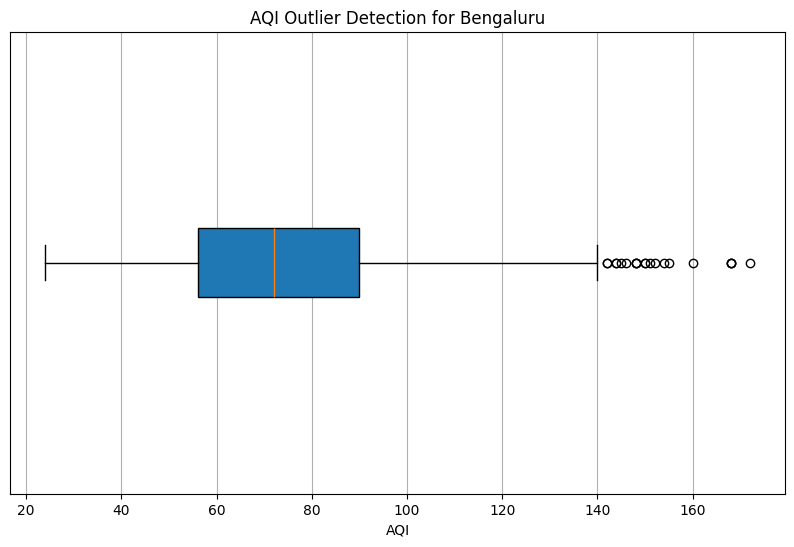

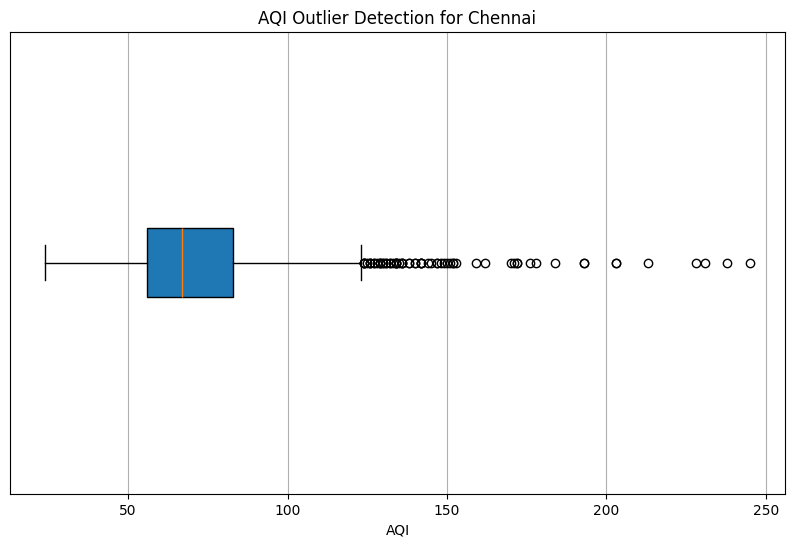

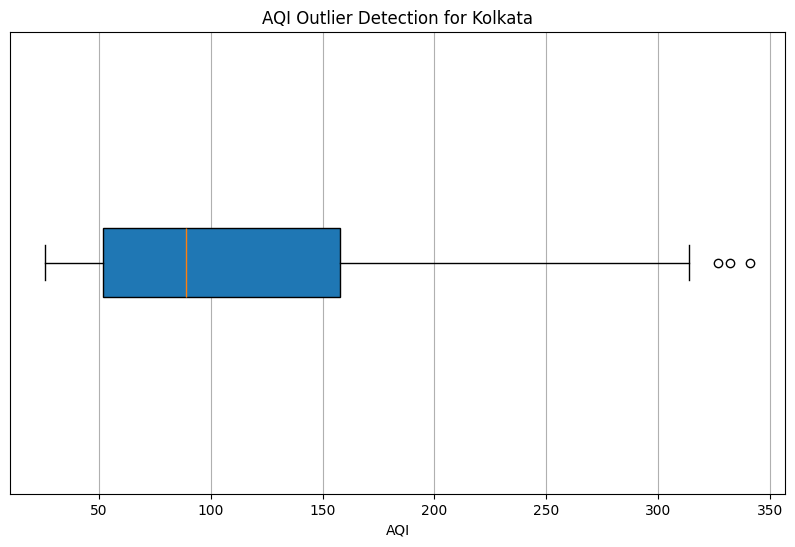

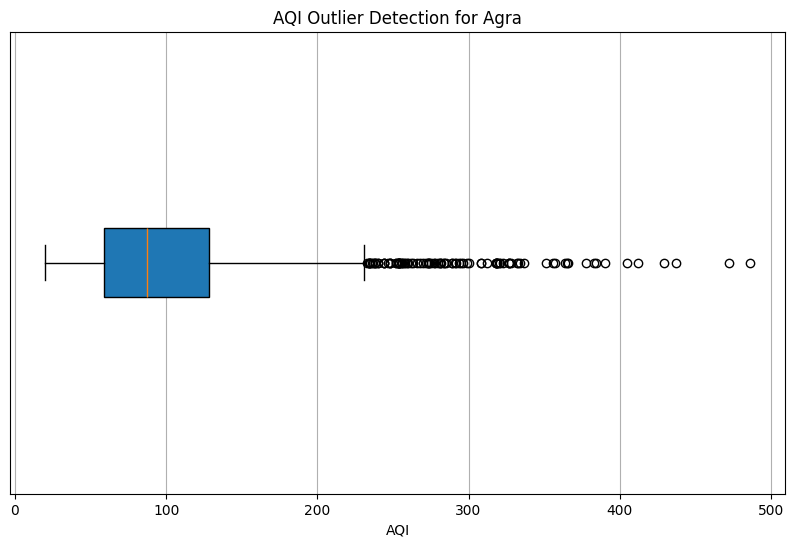

All box plots generated.


In [20]:
# Load the data file
try:
    df = pd.read_csv('all_cities_aqi_combined.csv')
    print("File 'all_cities_aqi_combined.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'all_cities_aqi_combined.csv' not found. Please ensure the file is in the correct directory.")
    sys.exit()

# Handle null AQI values by filling with the mean of each city
print("\nHandling Null AQI Values")
print("Number of null values before imputation:", df['AQI'].isnull().sum())

df['AQI'] = df.groupby('City')['AQI'].transform(lambda x: x.fillna(x.mean()))

print("Number of null values after imputation:", df['AQI'].isnull().sum())

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Generate box plots for each city
print("\nGenerating Box Plots for Outlier Detection")
cities = df['City'].unique()

for city in cities:
    city_df = df[df['City'] == city].dropna(subset=['AQI'])
    if not city_df.empty:
        plt.figure(figsize=(10, 6))
        plt.boxplot(city_df['AQI'], vert=False, patch_artist=True)
        plt.title(f'AQI Outlier Detection for {city}')
        plt.xlabel('AQI')
        plt.yticks([])
        plt.grid(True)
        plt.show()
        plt.close()
    else:
        print(f"No data available for city '{city}'. Skipping plot.")

print("All box plots generated.")

## 🧮 Outlier Removal Using IQR Method

To improve data quality and reduce noise, we apply the **Interquartile Range (IQR)** method to remove AQI outliers for each city.

### 🔍 Methodology
- For each city:
  - Calculate **Q1 (25th percentile)** and **Q3 (75th percentile)**
  - Compute **IQR = Q3 - Q1**
  - Define bounds:
    - **Lower Bound** = Q1 − 1.5 × IQR
    - **Upper Bound** = Q3 + 1.5 × IQR
  - Filter out AQI values outside these bounds

### 🧼 Data Update
- The cleaned DataFrame excludes extreme AQI values
- Ensures more stable and reliable input for modeling

### 📊 Post-Cleaning Visualization
- Generates updated box plots for each city
- Helps verify that outliers have been effectively removed
- Uses subtle grid styling for improved readability

### ✅ Output
- Cleaned AQI distributions for each city
- Confirmation that the DataFrame has been updated

> 📌 *Removing outliers helps prevent skewed model training and improves generalization.*

['Agra' 'Bengaluru' 'Chennai' 'Delhi' 'Gurugram' 'Kolkata' 'Mumbai' 'Pune']


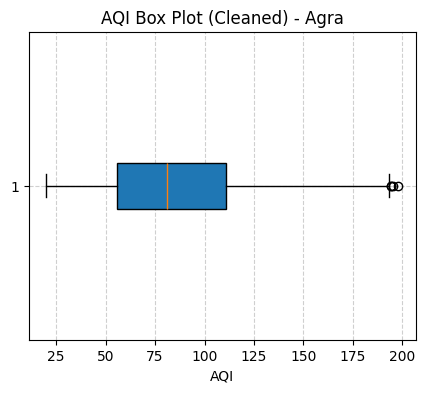

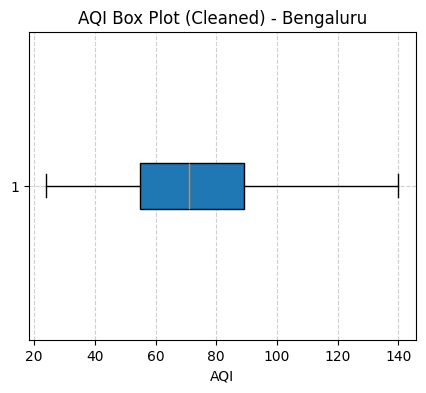

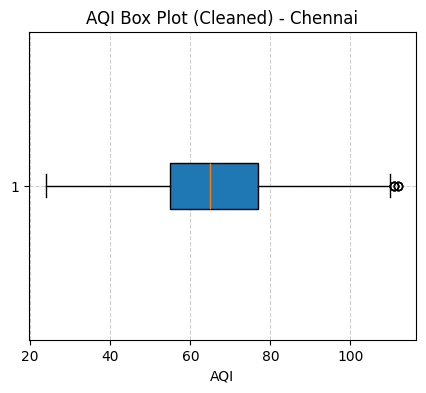

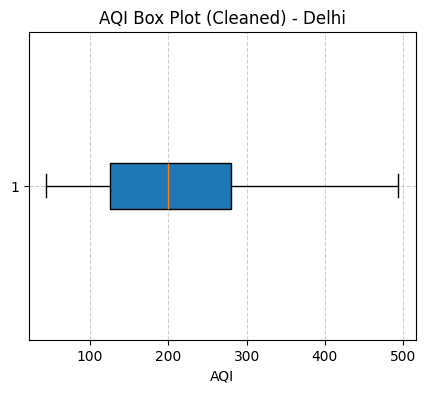

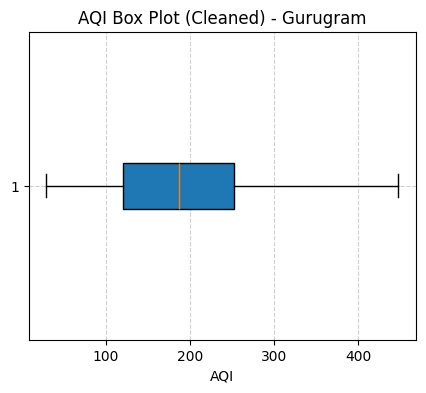

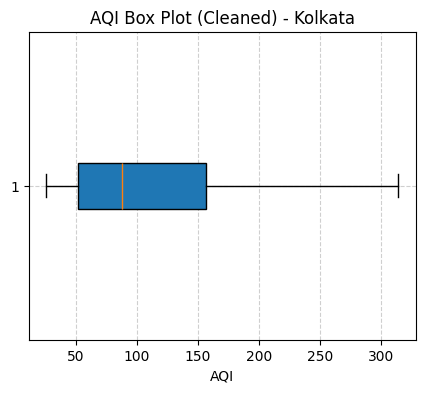

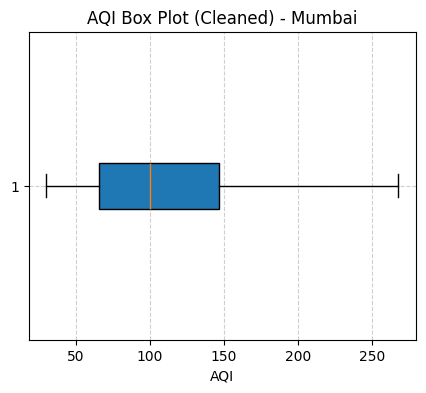

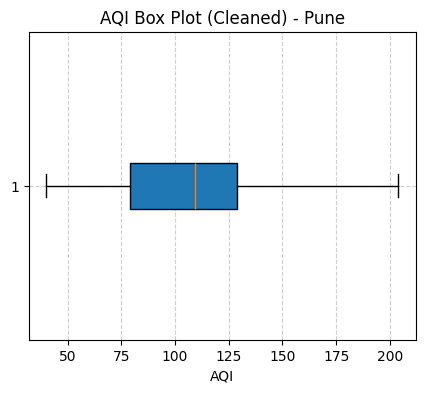

Outliers removed for each city. DataFrame updated.


In [23]:
def remove_outliers_iqr(city_df):
    Q1 = city_df["AQI"].quantile(0.25)
    Q3 = city_df["AQI"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return city_df[(city_df["AQI"] >= lower_bound) & (city_df["AQI"] <= upper_bound)]

df = df.groupby("City", group_keys=False).apply(remove_outliers_iqr)

print(df["City"].unique())

for city in df["City"].unique():
    city_data = df[df["City"] == city]["AQI"]

    plt.figure(figsize=(5, 4))
    plt.boxplot(city_data, vert=False, patch_artist=True)
    plt.title(f"AQI Box Plot (Cleaned) - {city}")
    plt.xlabel("AQI")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

print("Outliers removed for each city. DataFrame updated.")

## 🌤️ Seasonal AQI Trend Analysis

To understand how air quality fluctuates throughout the year, we analyze **monthly AQI averages** across cities.

### 📥 Data Preparation
- Load cleaned AQI dataset from `all_cities_cleaned.xlsx`
- Convert `'Date'` column to `datetime` format
- Extract **month** and **year** from each date

### 📊 Trend Aggregation
- Group data by `City` and `Month`
- Compute **average AQI** for each city-month combination
- Resulting DataFrame (`seasonal_trend`) captures seasonal patterns

### 📈 Visualization
- Use `seaborn.lineplot()` to plot AQI trends across months
- Each city is represented by a distinct line with markers
- X-axis labeled with month abbreviations for clarity
- Grid and legend enhance readability

### 🔍 Insights
This plot helps identify:
- Cities with **seasonal pollution spikes** (e.g., winter smog)
- Periods of **relatively clean air**
- Comparative trends across geographic regions

> 💡 *Seasonal analysis is crucial for designing targeted interventions and public health advisories.*

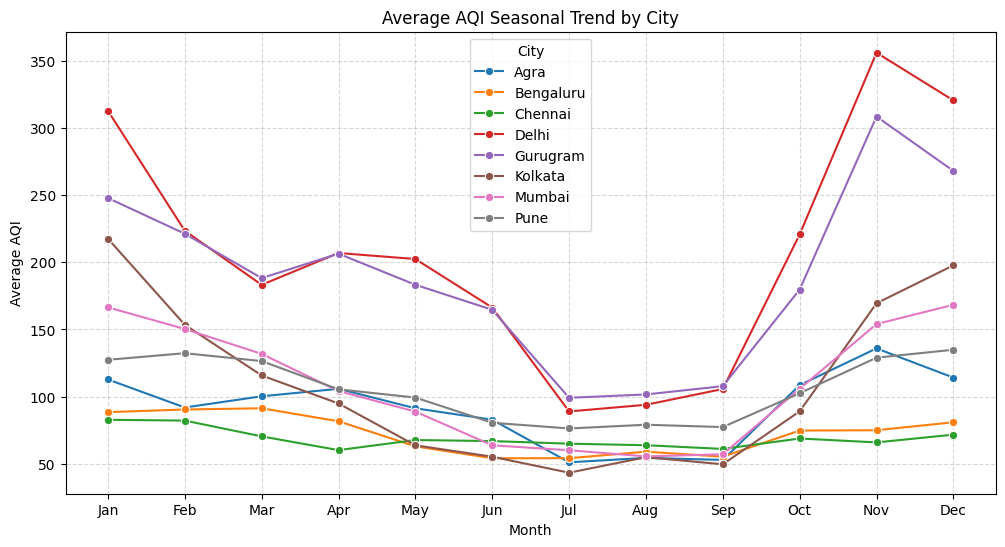

In [24]:
# Read your dataset
df = pd.read_excel("all_cities_cleaned.xlsx")

# Ensure Date column is datetime
df["Date"] = pd.to_datetime(df["Date"])

# Extract month and year
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year

# Group by city and month to get seasonal trend
seasonal_trend = df.groupby(["City", "Month"])["AQI"].mean().reset_index()

# Plot seasonal trend for each city
plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_trend, x="Month", y="AQI", hue="City", marker="o")
plt.title("Average AQI Seasonal Trend by City")
plt.xlabel("Month")
plt.ylabel("Average AQI")
plt.xticks(range(1, 13), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="City")
plt.show()


## 🧠 Feature Engineering & Data Splitting

To prepare the dataset for machine learning modeling, we extract relevant features and split the data into training and testing sets.

### 🛠️ Feature Construction
- **Date Conversion**: Ensure `'Date'` column is in `datetime` format
- **Temporal Features**:
  - `Month`: Captures seasonal effects
  - `DayOfYear`: Encodes time progression within the year
- **Categorical Encoding**:
  - `City`: Transformed using `LabelEncoder` to convert city names into numeric values (`City_encoded`)

### 🎯 Target Variable
- `AQI`: The value we aim to predict

### ✂️ Train-Test Split
- Split the dataset into:
  - `X_train`, `y_train`: 80% for training
  - `X_test`, `y_test`: 20% for evaluation
- `random_state=42` ensures reproducibility

> 📌 *These features capture both spatial (city) and temporal (month, day) dimensions of AQI variation, forming the foundation for predictive modeling.*

In [16]:
# --------------------
# Feature Preparation
# --------------------
df["Date"] = pd.to_datetime(df["Date"])
df["Month"] = df["Date"].dt.month
df["DayOfYear"] = df["Date"].dt.dayofyear

city_encoder = LabelEncoder()
df["City_encoded"] = city_encoder.fit_transform(df["City"])

X = df[["City_encoded", "Month", "DayOfYear"]]
y = df["AQI"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Model Performance:
                Model        MAE        R²
3            XGBoost  26.907622  0.754856
2  Gradient Boosting  27.728715  0.747920
1      Random Forest  30.986990  0.679733
0  Linear Regression  56.725090  0.019005

Best Model: XGBRegressor (R² = 0.755)

Predicted AQI: 200.86064


## 🤖 Model Selection for AQI Prediction

To evaluate different approaches for predicting AQI, we define a set of machine learning models with tuned hyperparameters:

### 🧪 Models to Compare
- **Linear Regression**  
  A simple baseline model that assumes a linear relationship between features and AQI.

- **Random Forest Regressor**  
  An ensemble of decision trees that reduces overfitting and captures non-linear patterns.  
  - `n_estimators=200`: Number of trees  
  - `random_state=42`: Ensures reproducibility

- **Gradient Boosting Regressor**  
  Builds trees sequentially to correct errors from previous ones.  
  - `n_estimators=200`: Number of boosting stages  
  - `random_state=42`: For consistent results

- **XGBoost Regressor**  
  A powerful and efficient gradient boosting implementation.  
  - `n_estimators=300`: More boosting rounds  
  - `learning_rate=0.1`: Controls step size  
  - `max_depth=6`: Limits tree depth  
  - `subsample=0.8`, `colsample_bytree=0.8`: Prevents overfitting  
  - `random_state=42`: For reproducibility

> 📌 *These models offer a mix of simplicity, interpretability, and predictive power. We'll compare their performance to select the best fit for AQI forecasting.*

In [27]:
-models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

## 📊 Model Evaluation & Selection

After training multiple models, we evaluate their performance on the test set using two key metrics:

### 🧪 Evaluation Metrics
- **MAE (Mean Absolute Error)**: Measures average prediction error in AQI units
- **R² (R-squared Score)**: Indicates how well the model explains variance in AQI values

### 🔁 Workflow
- Train each model on `X_train`, `y_train`
- Predict AQI values for `X_test`
- Compute MAE and R² for each model
- Track the best-performing model based on highest R²

### 🏆 Results Summary
- All results are stored in a DataFrame and sorted by R²
- The model with the highest R² is selected as the **best model**

> 📌 *This comparison helps identify the most accurate and generalizable model for AQI prediction across cities and seasons.*

In [28]:
-results = []
best_model = None
best_r2 = -np.inf

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MAE": mae, "R²": r2})
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = model

results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print("\nModel Performance:\n", results_df)

print(f"\nBest Model: {type(best_model).__name__} (R² = {best_r2:.3f})")


Model Performance:
                Model        MAE        R²
3            XGBoost  26.907622  0.754856
2  Gradient Boosting  27.728715  0.747920
1      Random Forest  30.986990  0.679733
0  Linear Regression  56.725090  0.019005

Best Model: XGBRegressor (R² = 0.755)


## 🔍 Hyperparameter Tuning with GridSearchCV (XGBoost)

To optimize the performance of our XGBoost model, we perform **grid search** over a range of hyperparameters using cross-validation.

### 🎯 Objective
- Minimize **Mean Absolute Error (MAE)** using 5-fold cross-validation
- Identify the best combination of parameters for generalization

### 🧪 Parameters Tuned
- `n_estimators`: Number of boosting rounds → `[100, 200, 300]`
- `max_depth`: Maximum tree depth → `[3, 5, 7]`
- `learning_rate`: Step size shrinkage → `[0.01, 0.1, 0.2]`
- `subsample`: Fraction of samples used per tree → `[0.7, 0.8, 1.0]`
- `colsample_bytree`: Fraction of features used per tree → `[0.7, 0.8, 1.0]`

### ⚙️ GridSearch Setup
- Estimator: `XGBRegressor` with `objective='reg:squarederror'`
- Scoring metric: `neg_mean_absolute_error`
- Parallel processing: `n_jobs=-1` for efficiency
- Verbose output for progress tracking

### 🏆 Results
- **Best Parameters**: Displayed after search completion
- **Final Evaluation**:
  - MAE on test set
  - R² score to assess model fit

> 📌 *Grid search helps fine-tune model behavior, improving accuracy and robustness for AQI prediction.*

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
MAE: 26.753673115855435
R² Score: 0.7580506620952498


## 🔮 AQI Prediction Function

To make real-time AQI predictions for any city and date, we define a reusable function `predict_aqi()`.

### 🧠 Function Logic
- **Inputs**:
  - `city_name`: Name of the city (e.g., `"Delhi"`)
  - `date_str`: Date in string format (e.g., `"2025-07-28"`)
- **Processing**:
  - Converts input date to `datetime`
  - Encodes city name using the fitted `LabelEncoder`
  - Extracts `Month` and `DayOfYear` as features
- **Output**:
  - Returns the predicted AQI value using the tuned `best_model`

### 🧪 Example Predictions
```python
predict_aqi("Delhi", "2025-07-28")
predict_aqi("Delhi", "2025-08-01")
predict_aqi("Mumbai", "2025-07-28")
predict_aqi("Delhi", current_date)  # Uses today's date

In [52]:
def predict_aqi(city_name, date_str):
    date = pd.to_datetime(date_str)
    city_code = city_encoder.transform([city_name])[0]
    features = pd.DataFrame([{
        "City_encoded": city_code,
        "Month": date.month,
        "DayOfYear": date.dayofyear
    }])
    return best_model.predict(features)[0]

# Example usage
print("\nPredicted AQI:", predict_aqi("Delhi", "2025-07-28"))
print("\nPredicted AQI:", predict_aqi("Delhi", "2025-08-01"))
print("\nPredicted AQI:", predict_aqi("Mumbai", "2025-07-28"))
from datetime import datetime
current_date = datetime.now().date()
print("\nPredicted AQI:", predict_aqi("Delhi", current_date))


Predicted AQI: 94.80851

Predicted AQI: 95.8261

Predicted AQI: 58.436718

Predicted AQI: 97.02967
